In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#### EDA

In [4]:
df_train.shape

(10000, 20)

In [5]:
df_test.shape

(5000, 19)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Есть пропуски в признаке:
1. LifeSquare (около 22%)
- если корреляция с похожими признаками площади будет высокой, то будет возможность избавиться от признака понижением размерности.

2. Healthcare_1 (около 48%)
- слишком много пропусков, нужно внимательно изучить признак. 

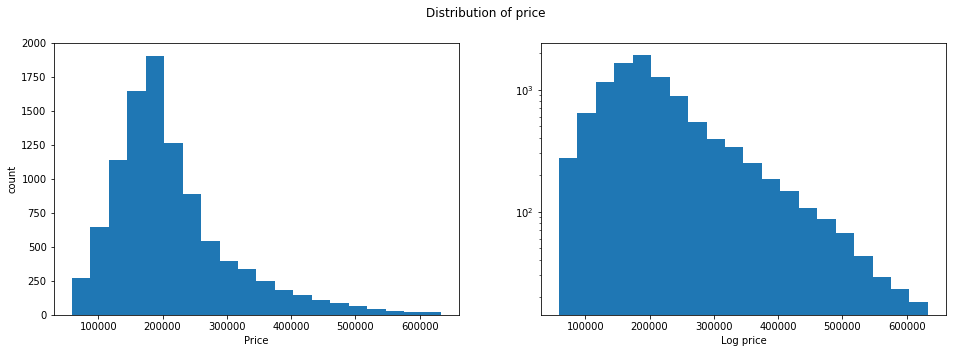

In [7]:
plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.hist(df_train['Price'], bins=20)
plt.xlabel('Price')
plt.ylabel('count')

plt.subplot(122)
plt.hist(df_train['Price'], bins=20, log=True)
plt.xlabel('Log price')

plt.suptitle('Distribution of price')

plt.show()

Целевая переменная выглядит адекватной.

Посмотрим на зависимость между HealthCare_1 и HelthCare_2

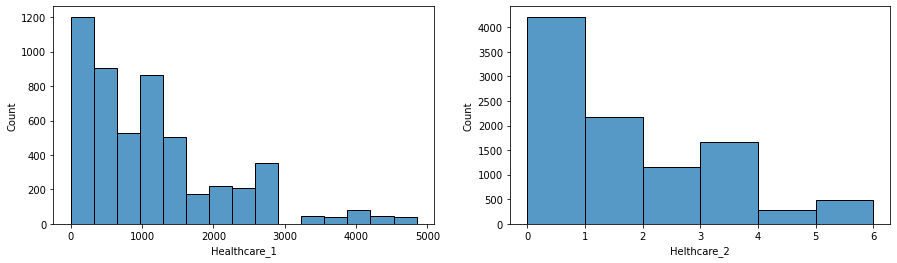

In [8]:
plt.figure(figsize=(15, 4))

plt.subplot(121)
sns.histplot(df_train['Healthcare_1'], bins=15)

plt.subplot(122)
sns.histplot(df_train['Helthcare_2'], bins=6)

plt.show()

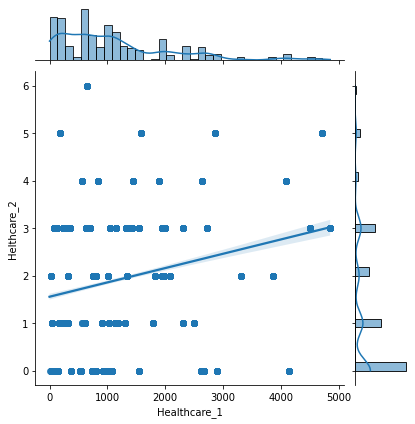

In [9]:
sns.jointplot(df_train['Healthcare_1'], df_train['Helthcare_2'], kind='reg')
plt.show()

Не похоже, что есть значительная связь между признаками Healthcare_1 и Helthcare_2. 

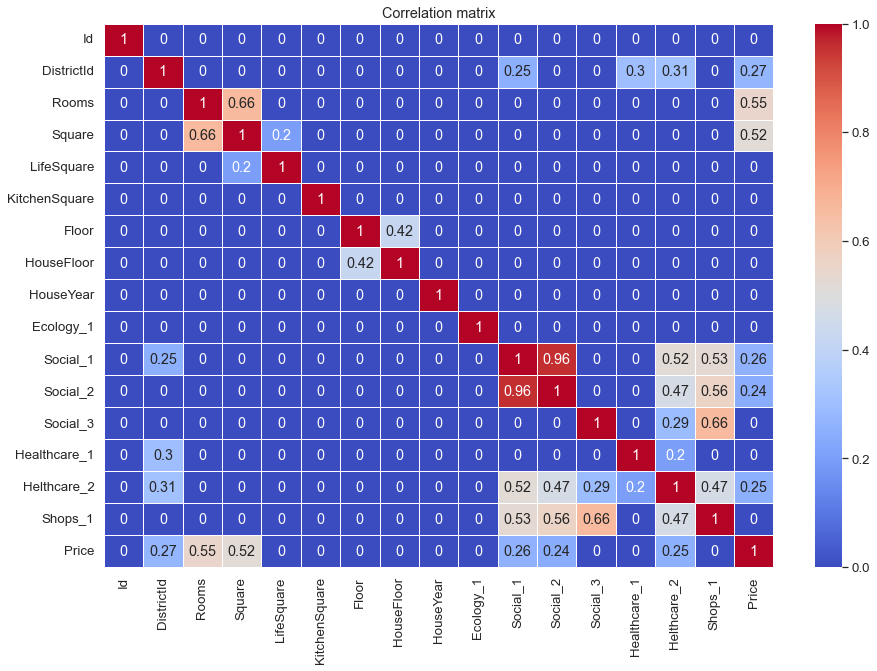

In [10]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=1.2)
corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.6, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

По матрице корреляций видно:

1. Корреляция между Healthcare_1 и Helthcare_2 почти отсутствует (Будет полезно знать при заполнении пропусков).

2. Корреляция по признакам площади так же почти отсутствует (за исключением признаков Rooms и Square).

3. Значительная корреляция между Social_1 и Social_2 - 0.96

4. Корреляции между:
    Rooms и Square         - 0.66
    Social_3 и Shops_1     - 0.66
    Social_2 и Shops_1     - 0.56
    Social_1 и Helthcare_2 - 0.52
    Social_2 и Helthcare_2 - 0.47
    Shops_1 и Helthcare_2  - 0.47
    Price и Rooms          - 0.55
    Price и Squre          - 0.52
    
5. Прочие незначительны.

In [11]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


По max значениям LifeSquare, KitchenSquare и, возможно, Social_3 и HouseYear видно, что, скорее всего, в этих признаках присутствуют выбросы.

LifeSquare

In [12]:
df_train.loc[(df_train['LifeSquare'] > 300), 'LifeSquare']

5183     461.463614
7010     410.639749
8000    7480.592129
9229     638.163193
Name: LifeSquare, dtype: float64

In [13]:
df_train.loc[(df_train['LifeSquare'] < 5), 'LifeSquare']

26      4.769174
119     0.795539
212     3.064320
227     1.944446
258     4.091945
          ...   
9331    4.660610
9462    3.288779
9869    0.873147
9938    2.637095
9982    1.855415
Name: LifeSquare, Length: 162, dtype: float64

Такие жилые площади явно можно считать выбросами, при создании функции по предобработке заменим их медианой

KitchenSquare

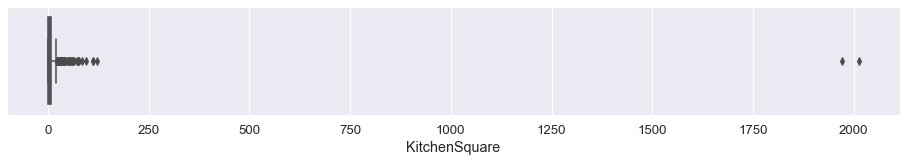

In [14]:
plt.figure(figsize=(16, 2))
sns.boxplot(df_train['KitchenSquare'])
plt.show()

In [15]:
df_train.loc[df_train['KitchenSquare'] > 50, 'KitchenSquare']

286      123.0
682       62.0
1728      72.0
2454      96.0
2785      84.0
2831      78.0
3240      66.0
3586      51.0
3725      60.0
3956      75.0
5002     112.0
5273      73.0
5663      58.0
5792      63.0
6293      51.0
6505    1970.0
7080      53.0
7601      58.0
7733     112.0
8329      54.0
9520    2014.0
Name: KitchenSquare, dtype: float64

Выбросы по площади кухни (всё что выше квантили 97.5% будем заменять медианой)

Social_3

In [16]:
df_train['Social_3'].describe()

count    10000.000000
mean         8.039200
std         23.831875
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

Судя по значению max и разнице значений mean и std можно сделать вывод что в Social_3 так же присутствуют выбросы.
Всё что выше квантили 75%(подобрано эксперементально) будем заменять медианой.

House_Year

In [17]:
df_train.loc[(df_train['HouseYear'] > 2021) | (df_train['HouseYear'] < 1900), 'HouseYear']

8828        4968
9163    20052011
Name: HouseYear, dtype: int64

И так же заменими меданой

#### Обработка пропусков

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Пропуски в LifeSquare будем заменять разницой значений Square и KitchenSquare 

#### Создание функции для обработки выбросов, пропусков и создания новых признаков

In [19]:
def transform(df):    
    
    # Замена выбросов
    
    # LifeSquare - пришлось переместить в конец функции, потому что находясь здесь по неведомой причине
    # эти строчки кода не выполняются

    #     df.loc[df['LifeSquare'] > 300, 'LifeSquare'] = df_train['LifeSquare'].median()
    #     df.loc[(df['LifeSquare'] < 10 ), 'LifeSquare'] = df_train['LifeSquare'].median()
    
    # KitchenSquare
    df.loc[df['KitchenSquare'] > np.quantile(df['KitchenSquare'], q=0.975), 'KitchenSquare']\
        = df_train['KitchenSquare'].median()
    
    # HouseYear
    df.loc[(df['HouseYear'] > 2021), 'HouseYear'] = np.median(df_train['HouseYear'])
    
    # Social_3
    df.loc[(df['Social_3'] > np.quantile(df['Social_3'], q=0.75)), 'Social_3'] = df_train['Social_3'].median()

    # Замена пропусков
    
    # LifeSquare
    df.loc[df['LifeSquare'].isna(), 'LifeSquare'] = df['Square'] - df['KitchenSquare']

    
    # HealthCare_1 не будем использовать для анализа ввиду большого количества пропусков.
    
    # Универсальная замена пропусков (на всякий случай)
    material_features = ['DistrictId', 'Rooms', 'Square', 'LifeSquare',
                             'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                             'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                             'Healthcare_1','Helthcare_2', 'Shops_1']
    for feature in material_features:
        df[f'{feature}'].fillna(df_train[f'{feature}'].median(), inplace=True)
    
    # Создание новых признаков
    
    # Создание dummi
    df = pd.get_dummies(df)
    
    # Создание DistrictSize (идея из файла baseline)
    district_size = df_train['DistrictId'].value_counts().reset_index()\
        .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left')
    
    # Target encoding (идея из файла baseline)
    med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
    med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
    df = df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
    
    # Замена пропусков новых признаков
    try:
        df['DistrictSize'].fillna(df_train['DistrictSize'].median(), inplace=True)
        df['MedPriceByDistrict'].fillna(df_train['MedPriceByDistrict'].median(), inplace=True)
    except:
        pass
    
    # Замена выбросов LifeSquare
    df.loc[df['LifeSquare'] > 300, 'LifeSquare'] = df_train['LifeSquare'].median()
    df.loc[(df['LifeSquare'] < 10 ), 'LifeSquare'] = df_train['LifeSquare'].median()
    return df

In [20]:
reduce_mem_usage(df_train)
print('')

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%



In [21]:
df_train = transform(df_train)

Посмотрим как изменились признаки после преобразования.

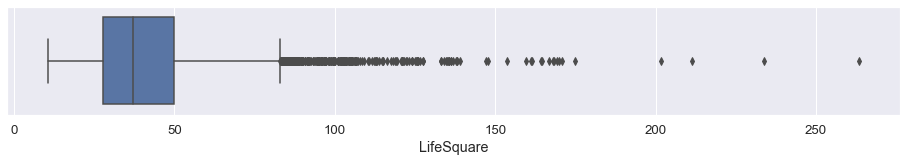

In [22]:
plt.figure(figsize=(16, 2))
sns.boxplot(df_train['LifeSquare'])
plt.show()

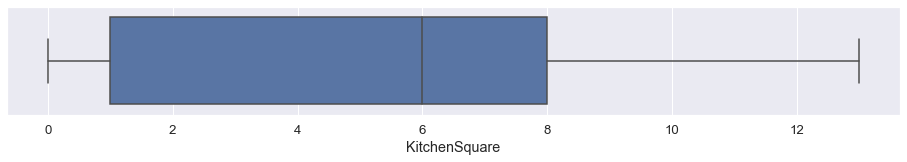

In [23]:
plt.figure(figsize=(16, 2))
sns.boxplot(df_train['KitchenSquare'])
plt.show()

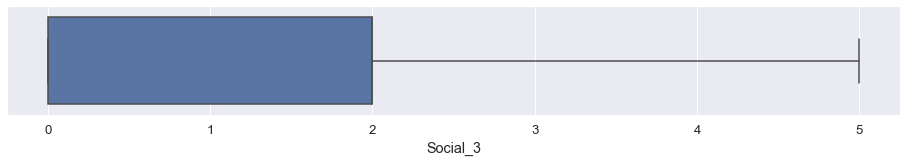

In [24]:
plt.figure(figsize=(16, 2))
sns.boxplot(df_train['Social_3'])
plt.show()

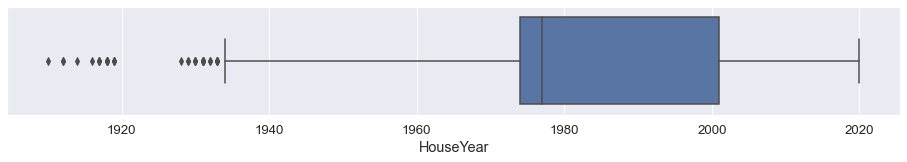

In [25]:
plt.figure(figsize=(16, 2))
sns.boxplot(df_train['HouseYear'])
plt.show()

In [26]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  10000 non-null  int16  
 1   DistrictId          10000 non-null  int16  
 2   Rooms               10000 non-null  float32
 3   Square              10000 non-null  float32
 4   LifeSquare          10000 non-null  float32
 5   KitchenSquare       10000 non-null  float32
 6   Floor               10000 non-null  int8   
 7   HouseFloor          10000 non-null  float32
 8   HouseYear           10000 non-null  int32  
 9   Ecology_1           10000 non-null  float32
 10  Social_1            10000 non-null  int8   
 11  Social_2            10000 non-null  int16  
 12  Social_3            10000 non-null  int16  
 13  Healthcare_1        10000 non-null  float32
 14  Helthcare_2         10000 non-null  int8   
 15  Shops_1             10000 non-null  int8   
 16  Price

Теперь, когда мы видим, что данные в порядке, можно приступать к отбору признаков

### Отбор признаков

In [27]:
df_train.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'DistrictSize',
 'MedPriceByDistrict']

In [28]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',
                 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
                 'Shops_1', 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A',
                 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B', 'DistrictSize',
                 'MedPriceByDistrict']
target_name = 'Price'

#### Преобразование датасета с учётом нужных и не нужных признаков

In [29]:
X = df_train[feature_names]
y = df_train[[target_name]]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.25)

### Построение модели

In [30]:
rfcv = RandomForestRegressor(criterion='mse',
                            random_state=66)
params = {'n_estimators' : [20, 40, 60, 80, 100],
         'min_samples_leaf' : range(2, 7),
         'max_depth' : range(10, 30)}

In [31]:
# %%time
# gs = GridSearchCV(rfcv, params,
#                  scoring='r2',
#                  cv=KFold(n_splits=5,
#                          random_state=66,
#                          shuffle=True),
#                  n_jobs=-1)
# gs.fit(X_train, y_train)

In [32]:
# gs.best_params_

In [33]:
rf = RandomForestRegressor(criterion='mse',
                          max_depth=25,
                          min_samples_leaf=3,
                          random_state=66,
                          n_estimators=120)

Метрика на валидационном датасете

In [34]:
rf.fit(X_train, y_train)
y_pred_valid = rf.predict(X_valid)
r2_score(y_valid, y_pred_valid)

0.7618585852966753

Метрика на тренировчном датасете

In [35]:
y_pred_train = rf.predict(X_train)
r2_score(y_train, y_pred_train)

0.9189009138744759

### Предсказание на тесте

In [36]:
df_test = transform(df_test)
df_test.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B',
 'DistrictSize',
 'MedPriceByDistrict']

In [37]:
X_test = df_test[feature_names]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rooms               5000 non-null   float64
 1   Square              5000 non-null   float64
 2   LifeSquare          5000 non-null   float64
 3   KitchenSquare       5000 non-null   float64
 4   Floor               5000 non-null   int64  
 5   HouseFloor          5000 non-null   float64
 6   HouseYear           5000 non-null   int64  
 7   Ecology_1           5000 non-null   float64
 8   Social_1            5000 non-null   int64  
 9   Social_2            5000 non-null   int64  
 10  Social_3            5000 non-null   int64  
 11  Helthcare_2         5000 non-null   int64  
 12  Shops_1             5000 non-null   int64  
 13  Ecology_2_A         5000 non-null   uint8  
 14  Ecology_2_B         5000 non-null   uint8  
 15  Ecology_3_A         5000 non-null   uint8  
 16  Ecolog

In [38]:
prediction = rf.predict(X_test)

In [39]:
submit = pd.read_csv('sample_submission.csv')
submit['Price'] = prediction

In [40]:
submit.to_csv('submit.csv', index=False)